# RQ4: To what extent can Machine Learning/NLP models identify the sensemaking aspect of feedback?

## Part 4: Using DistilBERT To Identify Sensemaking 1 vs. Sensemaking 2

In part 4 of RQ4, we are going to use a deep learning algorithm called DistilBERT to train a model to differentiate between the sensemaking 1 and sensemaking 2 rubrics in the feedback text. This uncased DistilBERT model was provided by the Hugging Face AI community. It was customised here to serve the needs of the sensemaking classifications in this study. Reference: [Class Balancing](https://medium.com/@nikviz/bert-handling-class-imbalance-in-language-models-7fe9ccc62cb6)

This is a different implementation of DistilBERT by using the Keras training library `ktrain` that sits on top of the Tensorflow Classifer. This is because the data for the second scenario (Sensemaking 1 vs. Sensemaking 2) is not balanced. Therefore we are going to use the `ktrain` library to use class penalty weights. These weights penalise the majority class to prevent it from overwhelm the minority class.

We used `SMOTE` in Part 1 and Part 2 of this research question for the machine learning models as it can be used on feature extracted data such as TF-IDF and LIWC. However, DistilBERT has its own encoder that extracts the features from the data. Therefore it accepts natural text which cannot be processed by `SMOTE`. 

We will also use this method to train the DistilBERT model for the third scenario (Sensemaking and Impact vs. the Rest) given in the Part 5 notebook for RQ4.

### 1. Loading the Initial Libraries and the Dataset

First, we need to load the initial set of libraries and the feedback data to be used in training the model.

In [1]:
# Importing the initial libraries
import pandas as pd
import re
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Loading the cleaned and wrangled feedback data
data = pd.read_csv('./LabelledFeedback/stage2.csv')

# Selecting the relevant columns only
data = data[['SentenceScoreRem', 'Rubric']]

# Checking the data
data.head()

,SentenceScoreRem,Rubric
0,Yuejing more in depth analysis is required and...,Sensemaking 1&Impact 1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1
2,The team submitted the workbook 23 days after ...,Sensemaking 2
3,Risk assessment and report needs work as discu...,Sensemaking 1
4,"""Good effort, Please refer to detailed feedbac...",Agency 2&Agency 1


### 2. Cleaning the Text and Preparing the Data

As was the case with the other models, we can use different NLP techniques such as tokenization and stop word removal to ensure that the model results are not affected by non-contexual words. We can define a function to clean the text.

In [3]:
# Defining a function to clean the feedback text
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tokens = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopwords]
    clean_text = ' '.join(filtered_tokens)
    return clean_text

# Applying the function to the data
data['text'] = data['SentenceScoreRem'].apply(clean_text)

# Splitting the preprocessed data into features and target variable
features = data['text']
target = data['Rubric']

# Checking the cleaned data
data[['text', 'Rubric']]

,text,Rubric
0,yuejing depth analysis required see link key c...,Sensemaking 1&Impact 1
1,team requested workbook better original mark,Impact 1
2,team submitted workbook days submission date kv,Sensemaking 2
3,risk assessment report needs work discussed tu...,Sensemaking 1
4,good effort please refer detailed feedback fil...,Agency 2&Agency 1
...,...,...
5754,q need use english communicate partiularly par...,Impact 1
5755,part b complicated needed explain rate change ...,Sensemaking 1
5756,q english exposition required,Impact 2
5757,made two errors finding determinant part b fin...,Sensemaking 1


As we can see in the above view, we have created a new column containing the clean text. Next, let us filter the data to include the sensemaking columns. Additionally, since we are trying to classify the data between sensemaking 1 and sensemaking 2, we need to remove the rows where both of them are present in the text.

In [4]:
# Filtering the data to only include the sensemaking rubrics and combinations
df_sensemaking = data[data["Rubric"].str.contains("Sensemaking")]

In [5]:
# Checking the filtered data
print(df_sensemaking['Rubric'].unique())

['Sensemaking 1&Impact 1' 'Sensemaking 2' 'Sensemaking 1'
 'Sensemaking 1&Impact 2' 'Agency 2&Sensemaking 1'
 'Sensemaking 2&Sensemaking 1' 'Sensemaking 2&Impact 2'
 'Sensemaking 1&Sensemaking 2' 'Sensemaking 1&Impact 3'
 'Sensemaking 2&Impact 1' 'Impact 1&Sensemaking 1'
 'Sensemaking 1&Agency 1' 'Agency 2&Sensemaking 2'
 'Sensemaking 1&Agency 2' 'Impact 2&Sensemaking 1'
 'Sensemaking 2&Agency 2' 'Agency 1&Sensemaking 1'
 'Impact 3&Sensemaking 1' 'Agency 3&Sensemaking 1'
 'Sensemaking 2&Agency 3' 'Agency 2&Sensemaking 1&Impact 1'
 'Sensemaking 2&Agency 1' 'Agency 2&Sensemaking 1&Agency 1'
 'Sensemaking 2&Sensemaking 1&Impact 1' 'Sensemaking 1&Impact 1&Agency 2']


In [6]:
# Removing the texts which have the Sensemaking 1 and Sensemaking 2 rubrics together
df_sensemaking = df_sensemaking[~df_sensemaking['Rubric'].str.contains('Sensemaking 2&Sensemaking 1')]
df_sensemaking = df_sensemaking[~df_sensemaking['Rubric'].str.contains('Sensemaking 1&Sensemaking 2')]

In [7]:
# Checking the filtered data
print(df_sensemaking['Rubric'].unique())

['Sensemaking 1&Impact 1' 'Sensemaking 2' 'Sensemaking 1'
 'Sensemaking 1&Impact 2' 'Agency 2&Sensemaking 1'
 'Sensemaking 2&Impact 2' 'Sensemaking 1&Impact 3'
 'Sensemaking 2&Impact 1' 'Impact 1&Sensemaking 1'
 'Sensemaking 1&Agency 1' 'Agency 2&Sensemaking 2'
 'Sensemaking 1&Agency 2' 'Impact 2&Sensemaking 1'
 'Sensemaking 2&Agency 2' 'Agency 1&Sensemaking 1'
 'Impact 3&Sensemaking 1' 'Agency 3&Sensemaking 1'
 'Sensemaking 2&Agency 3' 'Agency 2&Sensemaking 1&Impact 1'
 'Sensemaking 2&Agency 1' 'Agency 2&Sensemaking 1&Agency 1'
 'Sensemaking 1&Impact 1&Agency 2']


Next, we will define a function to create the target variable for this case. The target variable will contain a 1 if the text contains the Sensemaking 1 rubric and 0 otherwise meaning that the Sensemaking 2 rubric is present instead.

In [8]:
# Defining a function to create the target variable
def sensemaking(rub):

    if 'Sensemaking 1' in rub:

        return 1

    else:

        return 0

# Applying the above function to the data    
df_sensemaking['label'] = df_sensemaking['Rubric'].apply(lambda x : sensemaking(x))

# Checking the new column
df_sensemaking[['text', 'Rubric', 'label']]

,text,Rubric,label
0,yuejing depth analysis required see link key c...,Sensemaking 1&Impact 1,1
2,team submitted workbook days submission date kv,Sensemaking 2,0
3,risk assessment report needs work discussed tu...,Sensemaking 1,1
6,lacked depth detail,Sensemaking 1,1
7,failed cite use prescribed texts answers simpl...,Sensemaking 2,0
...,...,...,...
5751,q f x g x incorrect shown found stationary poi...,Sensemaking 1,1
5753,part c actually still part b part c required c...,Sensemaking 1&Impact 1,1
5755,part b complicated needed explain rate change ...,Sensemaking 1,1
5757,made two errors finding determinant part b fin...,Sensemaking 1,1


In [9]:
# Separately storing the features and the label
features = df_sensemaking['text']
target = df_sensemaking['label']

In [15]:
# Checking the value counts of the target variable
df_sensemaking['label'].value_counts()

1    2733
0     424
Name: label, dtype: int64

As shown by the value counts above, there is a severe imbalance in the data. Unlike the technique used for the machine learning models, we will be using class weights with Keras and Tensorflow. First, let us install and import the `ktrain` library that is required for this.

In [11]:
# Installing the ktrain library
pip install ktrain

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Importing the required libraries including ktrain
#Reference: https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c
import ktrain
from sklearn.model_selection import train_test_split

We are going to start the process of preparing the data and the ktrain preprocessor. Simultaneously, we will also split the data into the training set and validation sets.

In [16]:
# Creating a list containing a set of the two classes
classes =  list(set(df_sensemaking.label))

# Splitting the data into training and validation test sets
X_train, X_test, y_train, y_test = train_test_split(df_sensemaking.text, df_sensemaking.label, test_size=0.02, random_state=42)

In [17]:
# Checking the value counts of the training data
y_train.value_counts()

1    2677
0     416
Name: label, dtype: int64

`ktrain` has a function called text that will help preprocess the feedback text. We can load the text into the text preprocessor and create an array containing the preprocessed text with our intended parameters.

In [18]:
# Importing the necessary module
from ktrain import text

# Preprocessing the text
trn, val, preproc = text.texts_from_array(x_train=X_train.values, y_train=y_train.values,
                                          x_test=X_test.values, y_test=y_test.values,
                                                                   class_names=classes,
                                                                   val_pct=0.1, 
                                                                   max_features=30000, 
                                                                   maxlen=350,
                                                                   preprocess_mode='distilbert',
                                                                   ngram_range=1)

# Building the tensorflow model with the keras preprocessed text 
model = text.text_classifier('distilbert', train_data=trn, preproc=preproc)

preprocessing train...
language: en
train sequence lengths:
	mean : 10
	95percentile : 28
	99percentile : 43


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 25
	99percentile : 30


task: text classification
Is Multi-Label? False
maxlen is 350
done.


### 3. Training the Model and Finding the Best Learning Rate

In this next phase, we will setup the class weights with the help of `sklearn.utils`. Once we have created them, we can use them and the preprocessing data to fit the model trainer. We will use the `learner` function to find the best loss function aka the most optimum learning rate from multiple trainers and select the best model.

[3.71754808 0.57769892]
{0: 3.717548076923077, 1: 0.577698916697796}
simulating training for different learning rates... this may take a few moments...
Epoch 1/5
515/515 [==============================] - 93s 155ms/step - loss: 0.5495 - accuracy: 0.6945
Epoch 2/5
515/515 [==============================] - 79s 154ms/step - loss: 0.2892 - accuracy: 0.8980
Epoch 3/5
515/515 [==============================] - 79s 154ms/step - loss: 0.4258 - accuracy: 0.8711
Epoch 4/5
515/515 [==============================] - 35s 67ms/step - loss: 1.5701 - accuracy: 0.8101


done.
Visually inspect loss plot and select learning rate associated with falling loss


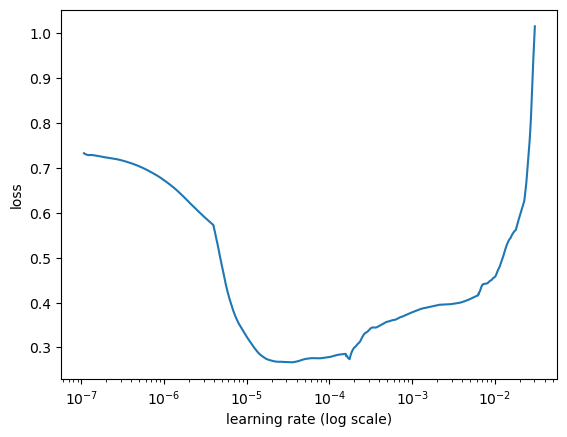



begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
516/516 [==============================] - 91s 159ms/step - loss: 0.4835 - accuracy: 0.7740 - val_loss: 0.4616 - val_accuracy: 0.7500
Epoch 2/3
516/516 [==============================] - 80s 155ms/step - loss: 0.2810 - accuracy: 0.8943 - val_loss: 0.4982 - val_accuracy: 0.8281
Epoch 3/3
516/516 [==============================] - 80s 154ms/step - loss: 0.1955 - accuracy: 0.9315 - val_loss: 0.4119 - val_accuracy: 0.8125


In [19]:
# Importing the necessary module to help us create the class weights
#from sklearn.utils import class_weight
import sklearn.utils as ut

# Creating weights to handle class imbalance
class_weights = ut.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )

# Printing the class weights
print(class_weights)

# Empty dictionary to store the weights
weights={}

# For loop to store the weights and their indexes in the dictionary
for index, weight in enumerate(class_weights) :
    weights[index]=weight

# Printing the enumerated weights    
print(weights)

# Applying the weights to the learner
learner =  ktrain.get_learner(model, train_data=trn, val_data=val,batch_size=6)

# Finding the learning rate
learner.lr_find(show_plot=True,max_epochs=5)

# Using the best learning rate and running for 3 epochs using autofit
learner.autofit(2e-5, 3,class_weight = weights)

As shown in the above loss plot, we can visually see the best learning rate based on the falling loss. The accuracy achieved on the last epoch was also 93% which is very good. We use the `validate` function now to observe the other metrics such as precision and recall.

In [20]:
# Validating the result
learner.validate()

2/2 [==============================] - 2s 202ms/step
              precision    recall  f1-score   support

           0       0.36      0.62      0.45         8
           1       0.94      0.84      0.89        56

    accuracy                           0.81        64
   macro avg       0.65      0.73      0.67        64
weighted avg       0.87      0.81      0.83        64



array([[ 5,  3],
       [ 9, 47]])

The model has achieveed a decent precision and recall of 87% and 81% respectively. Although, compared to the accuracy, this is not the desired result, it is still acceptable. 

In [21]:
# Saving the Model
# Optional Step to demonstrate how to save a model
learner.save_model('./SavedModels/DetectSensemakingRubric')
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('./SavedModels/DetectSensemakingRubric')